In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from brax import envs
from brax.io import mjcf
import jax
import flax.linen as nn
import jax.numpy as jnp
from wrappers import AutoResetWrapper

from custom_types import RNGKey, EnvState, Params
from typing import Any, Tuple, List
# from algorithms import QuaraticPPO, PPO
# from mo_algorithms import MO_PPO
from algorithms import MOPPO, PPOConfigs
from buffer import PPOTransition
from networks import GCMLP, GC_PPO_Policy
from functools import partial
from utils import shuffle_transitions
from mo_utils import sample_task
# , mo_ppo_exploraive_rollout, calculate_td_lambda_returns, build_scoring_fn

/home_nfs/runjun/python_envs/qdax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
critic_hidden_layers: Tuple[int, ...] = (128, 128)
actor_hidden_layers: Tuple[int, ...] = (128, 128)

vec_env = 2048

ppo_config = PPOConfigs(
    policy_learnng_rate=5e-4,
    critic_learning_rate=5e-4,
    clip_ratio=0.2,
    entropy_gain=0.0,
    discount=0.99,
    td_lambda_discount=0.95,
    rollout_length=128,
    vec_env=vec_env,
    mini_batch_size=512,
    critic_epochs=2,
    policy_epochs=2,
    learnable_std=False,
    initial_std=0.25,
    std_decay_rate=0.00005,
    min_std=0.1,
)


In [3]:
# set random seed
seed = 6666
loop_random_key = jax.random.PRNGKey(seed)
loop_random_key, subkey = jax.random.split(loop_random_key)
task_name = "ant"

# creat environment (Ant)
env = envs.create(env_name=task_name, episode_length=None, backend="mjx", auto_reset=False)
env = AutoResetWrapper(env) # custom auto reset


# preference_vector = jnp.array([2.0, 1.0, 1.0, 1.0])
# preference_vector = preference_vector / jnp.sqrt(jnp.sum(preference_vector**2))


# define networks
policy_network = GC_PPO_Policy(
    hidden_layer_sizes=actor_hidden_layers,
    action_dim=env.action_size,
    initial_std=0.1 * jnp.ones(env.action_size),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    kernel_init_final=jax.nn.initializers.orthogonal(0.01),
    # activation=nn.softplus,
    activation=nn.softplus,
    final_activation=jnp.tanh,
    # fixed_std=True,
    fixed_std=True,
)

critic_network = GCMLP(
    layer_sizes=critic_hidden_layers + (1,),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    activation=nn.softplus,
    final_activation=None,
)

In [4]:
ppo = MOPPO(
    env=env,
    policy_network=policy_network,
    critic_network=critic_network,
    ppo_configs=ppo_config,
    sample_fn=sample_task,
    include_last_action_in_obs=True,
)

ppo_training_state = ppo.init(subkey)

In [5]:
loop_random_key, subkey = jax.random.split(loop_random_key)
subkeys = jax.random.split(subkey, num=vec_env)
states = jax.vmap(env.reset)(subkeys)
last_actions = jnp.zeros((vec_env, env.action_size))

In [29]:
num_iterations = 1000


iteration_mean_returns = []
iteration_mean_rewards = []
# iteration_mean_log_std = []
# iteration_mean_gae = []



for i in range(num_iterations):
    (
        states, 
        last_actions, 
        ppo_training_state,
        loop_random_key
    ), transitions = ppo.train(
        states,
        last_actions,
        ppo_training_state,
        loop_random_key,
    )
    
    iteration_mean_rewards.append(jnp.mean(transitions.rewards).item())
    
    iteration_mean_returns.append(jnp.mean(transitions.td_lambda_returns).item())

    if (i + 1) % max([(num_iterations // 10), 1]) == 0:
        print(int((i + 1) / num_iterations * 100), "% complete")

10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
100 % complete


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

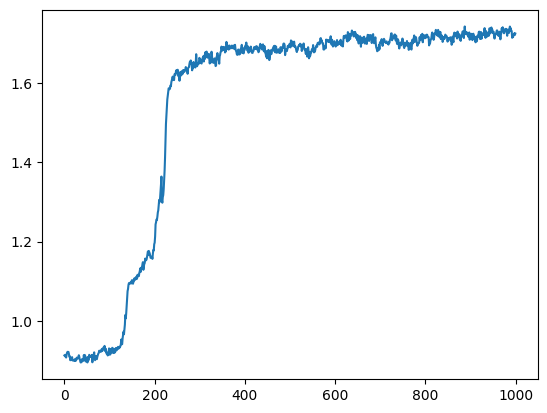

In [31]:
plt.plot(jnp.arange(num_iterations), iteration_mean_rewards)
# plt.plot(jnp.arange(num_iterations), iteration_mean_log_std)
plt.show()

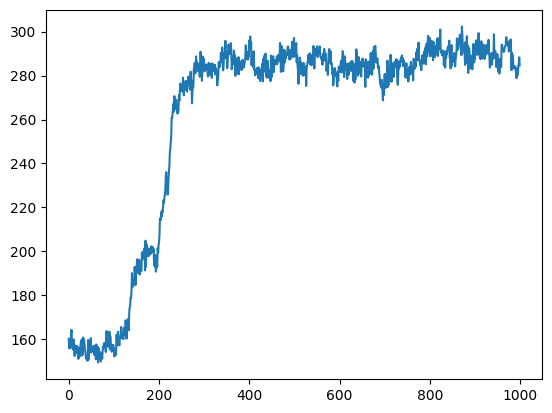

In [32]:
plt.plot(jnp.arange(num_iterations), iteration_mean_returns)
plt.show()

In [33]:
# plt.plot(jnp.arange(len(scores)), scores)
# plt.show()

In [34]:
# jnp.sum(transitions.dones)

In [35]:
# plt.hist(jnp.reshape(gaes, -1), bins=20)
# plt.show()

In [36]:
jnp.mean(
    states.reward
)

Array(5.2110095, dtype=float32)

In [37]:
ppo_training_state.current_std

Array(0.1, dtype=float32, weak_type=True)